# Packages and Libraries

# Work FLow
- `Packages and Libraries`
-  `Load raw audio data` from files in .WAV format that can be processed
-  `EDA`
-  `Spectral Representations` Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram.
-  `Conversion to TensorFlow` Convert the preprocessed data into a format suitable for the deep learning framework.
-  `Data Splitting` Split the dataset into training, validation, and testing sets.
-  `Model Building` Build your machine learning model using the preprocessed data.
-  `Converting to TFLite model`

In [1]:
import os
import json
import math
import wave
import h5py
import librosa
import pathlib
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf 
from sys import getsizeof
from tensorflow import keras
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import Audio
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

2024-03-05 16:04:32.323821: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 16:04:32.464364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 16:04:32.464422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 16:04:32.489686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 16:04:32.545766: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 16:04:32.546339: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Disable TensorFlow warnings and info messages
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Loading Raw Audio Data

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each speech command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

## Mount google drive
adisamproject@gmail.com

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATASET_PATH = "/content/drive/My Drive/2_Luganda/dataset"
# data_dir = pathlib.Path(DATASET_PATH)

## Dataset path

In [4]:
TRAIN_DATASET_PATH = 'Dataset/Train'
TEST_DATASET_PATH = 'Dataset/Test'

train_data_dir = pathlib.Path(TRAIN_DATASET_PATH)
test_data_dir = pathlib.Path(TEST_DATASET_PATH)

# Exploratory Data Analysis (EDA) 

## Labels (Train and Test Directories)

In [5]:
commands = np.array(tf.io.gfile.listdir(str(train_data_dir)))
print('Train commands labels:\n', commands)

Train commands labels:
 ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


In [6]:
commands = np.array(tf.io.gfile.listdir(str(test_data_dir)))
print('Test commands labels:\n', commands)

Test commands labels:
 ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Number of audio files

In [7]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)

        if os.path.isdir(subfolder_path):
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count

    return counts

### Training dataset

In [8]:
counts = count_audio_files_in_subfolders(train_data_dir)

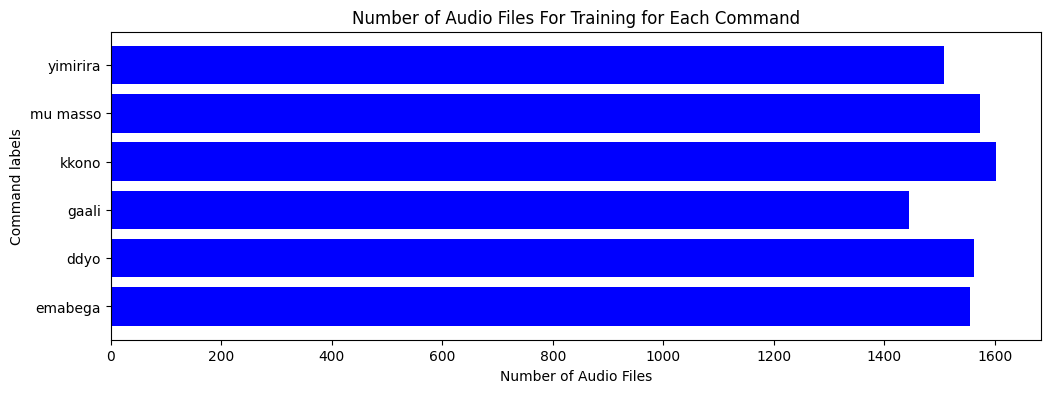

In [9]:
plt.figure(figsize=(12, 4))
plt.barh(list(counts.keys()), list(counts.values()), color='blue')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

### Test dataset

In [10]:
counts = count_audio_files_in_subfolders(test_data_dir)

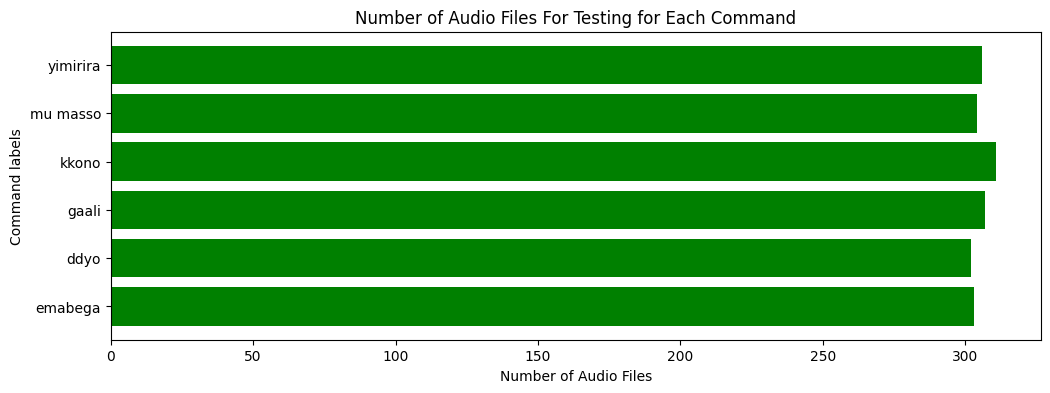

In [11]:
plt.figure(figsize=(12, 4))
plt.barh(list(counts.keys()), list(counts.values()), color='green')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Testing for Each Command')
plt.show()

## Audio Properties and Parameters
- using one audio file

In [12]:
SAMPLE_RATE = 16000

In [14]:
example_audio_path = os.path.join(TRAIN_DATASET_PATH, 'emabega', 'emabega #225.wav')
audio_signal, sample_rate = librosa.load(example_audio_path, sr=SAMPLE_RATE)
audio = wave.open(example_audio_path, 'rb')

In [15]:
num_channels = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
num_frames = audio.getnframes()
duration = num_frames / float(frame_rate)

In [16]:
print("Number of channels:    ", num_channels)
print("Sample width (bytes):  ", sample_width)
print("Frame rate (Hz):       ", frame_rate)
print("Number of frames:      ", num_frames)
print("Duration (s):          ", duration)
print("Parameters:            ", audio.getparams())

Number of channels:     1
Sample width (bytes):   2
Frame rate (Hz):        16000
Number of frames:       22720
Duration (s):           1.42
Parameters:             _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=22720, comptype='NONE', compname='not compressed')


In [17]:
audio.close()

### Visualize the audio waveform

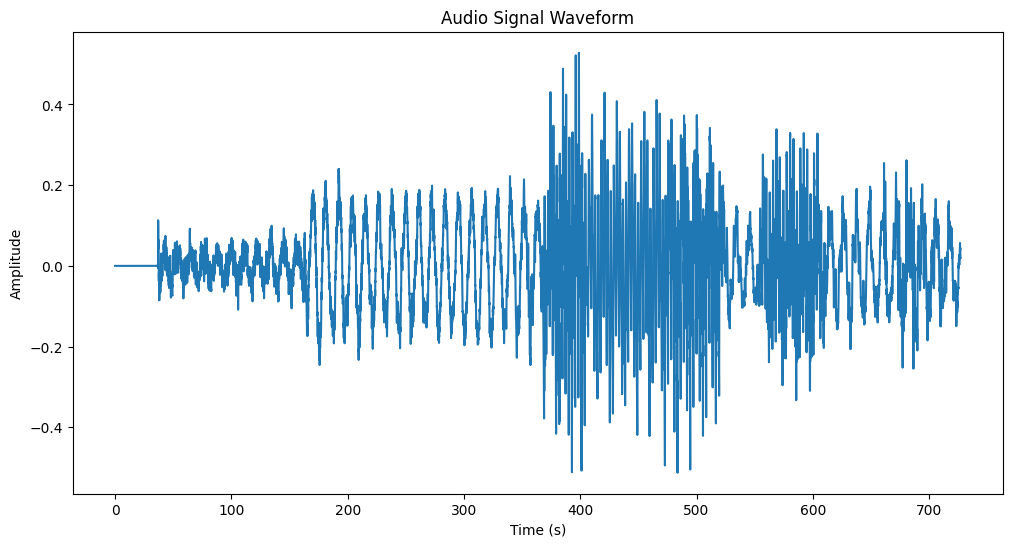

In [18]:
time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)

plt.figure(figsize=(12, 6))
plt.plot(time, audio_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Signal Waveform')
plt.show()

### Amplitude Distribution

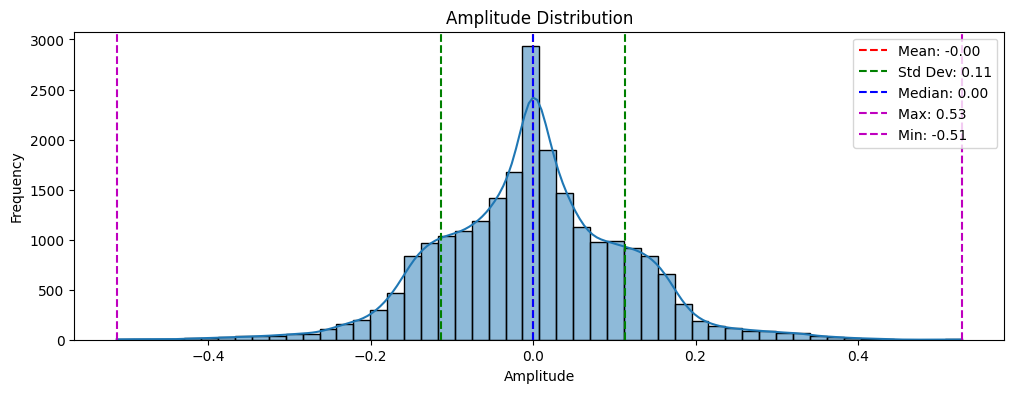

In [19]:
# Calculate statistical summary information
mean_amplitude = np.mean(audio_signal)
std_deviation = np.std(audio_signal)
max_amplitude = np.max(audio_signal)
min_amplitude = np.min(audio_signal)
median_amplitude = np.median(audio_signal)

# Plot the histogram with additional features
plt.figure(figsize=(12, 4))

# Plot the histogram
sns.histplot(audio_signal, bins=50, kde=True)

# Add vertical lines for statistical summary information
plt.axvline(mean_amplitude, color='r', linestyle='--', label=f'Mean: {mean_amplitude:.2f}')
plt.axvline(mean_amplitude + std_deviation, color='g', linestyle='--', label=f'Std Dev: {std_deviation:.2f}')
plt.axvline(mean_amplitude - std_deviation, color='g', linestyle='--')
plt.axvline(median_amplitude, color='b', linestyle='--', label=f'Median: {median_amplitude:.2f}')
plt.axvline(max_amplitude, color='m', linestyle='--', label=f'Max: {max_amplitude:.2f}')
plt.axvline(min_amplitude, color='m', linestyle='--', label=f'Min: {min_amplitude:.2f}')

# Set plot title and labels
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Play audio file

In [20]:
Audio(example_audio_path)

# Split into Train and validation

In [21]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_data_dir,
    batch_size=64,
    validation_split=0.28,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 9248 files belonging to 6 classes.
Using 6659 files for training.
Using 2589 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


## The shape of the audio clip
- (batch, samples, channels)

In [22]:
element_spec = train_ds.element_spec
print(element_spec)

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [23]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [24]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [25]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [16000,1] and element 23 had shape [16000,2]. [Op:IteratorGetNext] name: 

# Preparing Test dataset

In [25]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_data_dir,
    batch_size=64,
    validation_split=None,  # No need to split the test dataset
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    shuffle=False  # Disable shuffling for the test dataset
)

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

# Shard the test dataset
test_ds = test_ds.shard(num_shards=2, index=0)

Found 115 files belonging to 6 classes.


In [26]:
for example_audio, example_labels in test_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


# Plot a few audio waveforms:

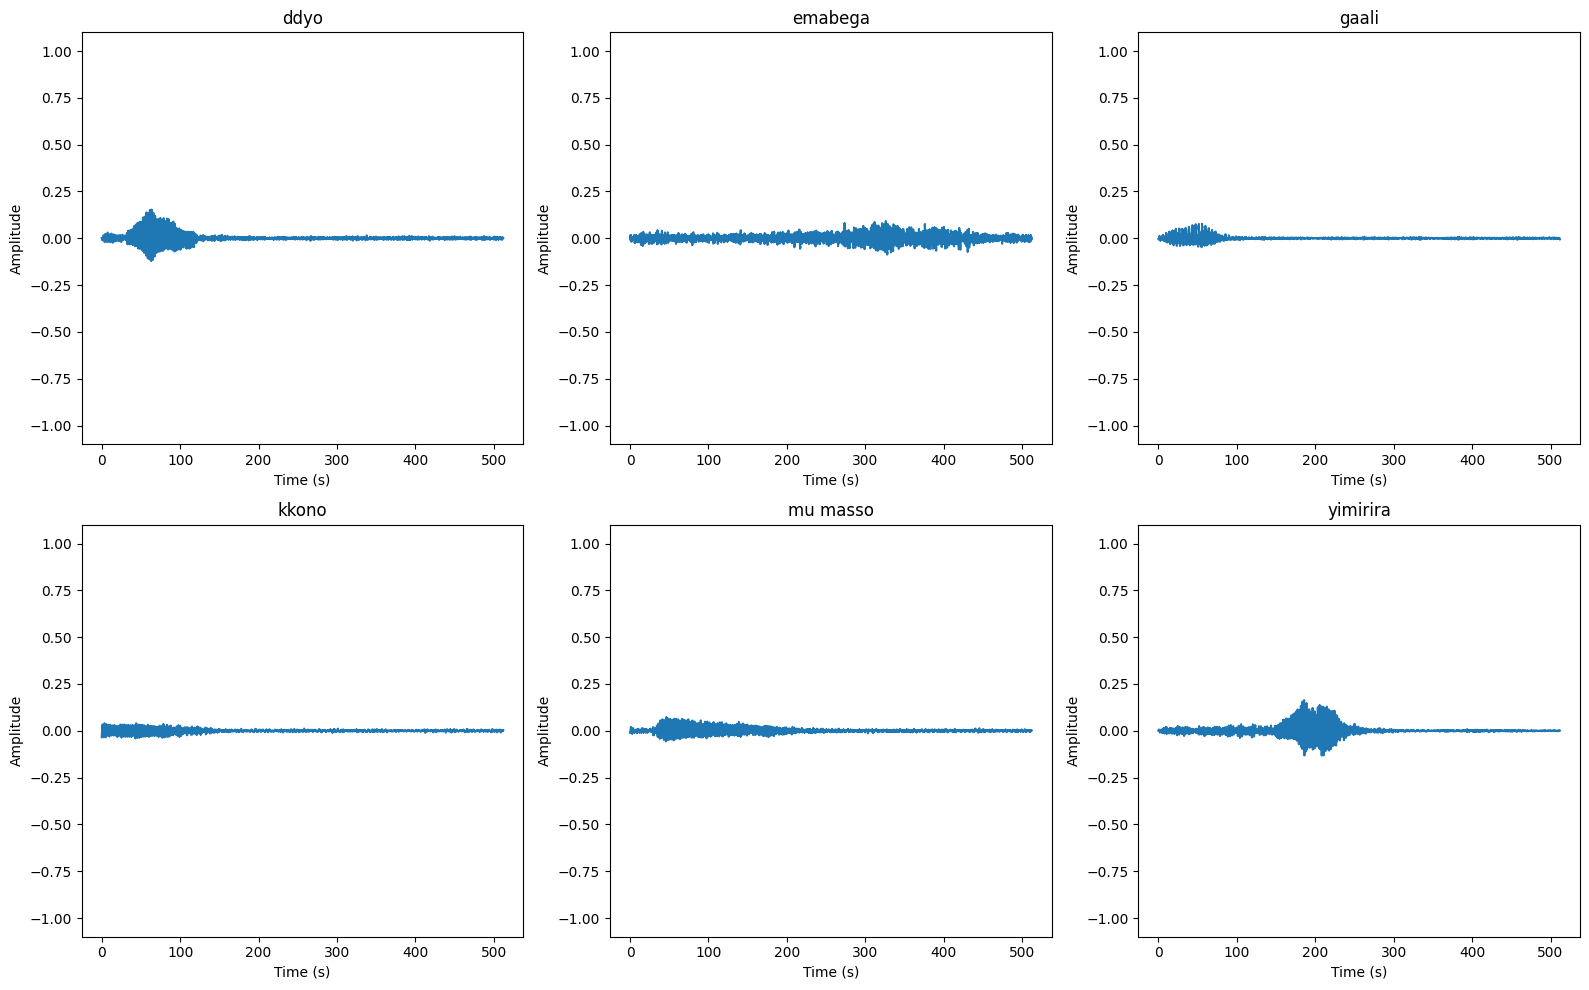

In [27]:
import librosa.display

label_names_slice = label_names[:6]  # Select the first six labels
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)
    plt.plot(time, audio_signal)
    plt.title(label_names_slice[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()


# Feature Extraction

In [28]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

## Tensorized waveform
The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio.

In [29]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Visualization of spectrogram

In [30]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform and spectrogram.

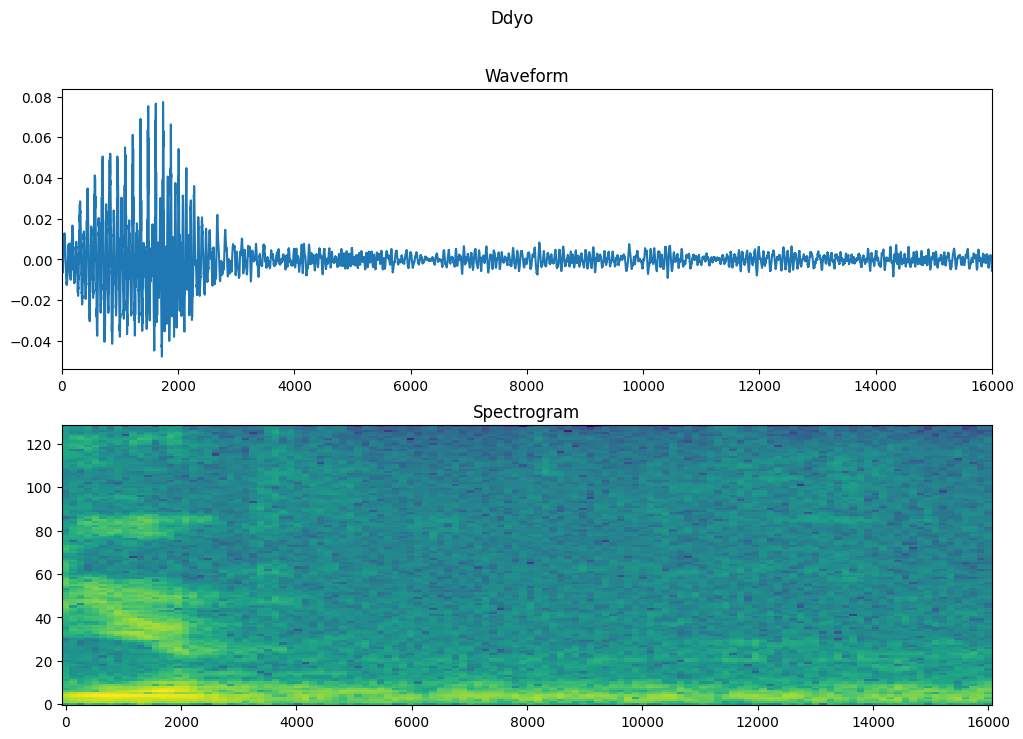

In [31]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets

In [32]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

## Visualization of the spectrograms

In [34]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

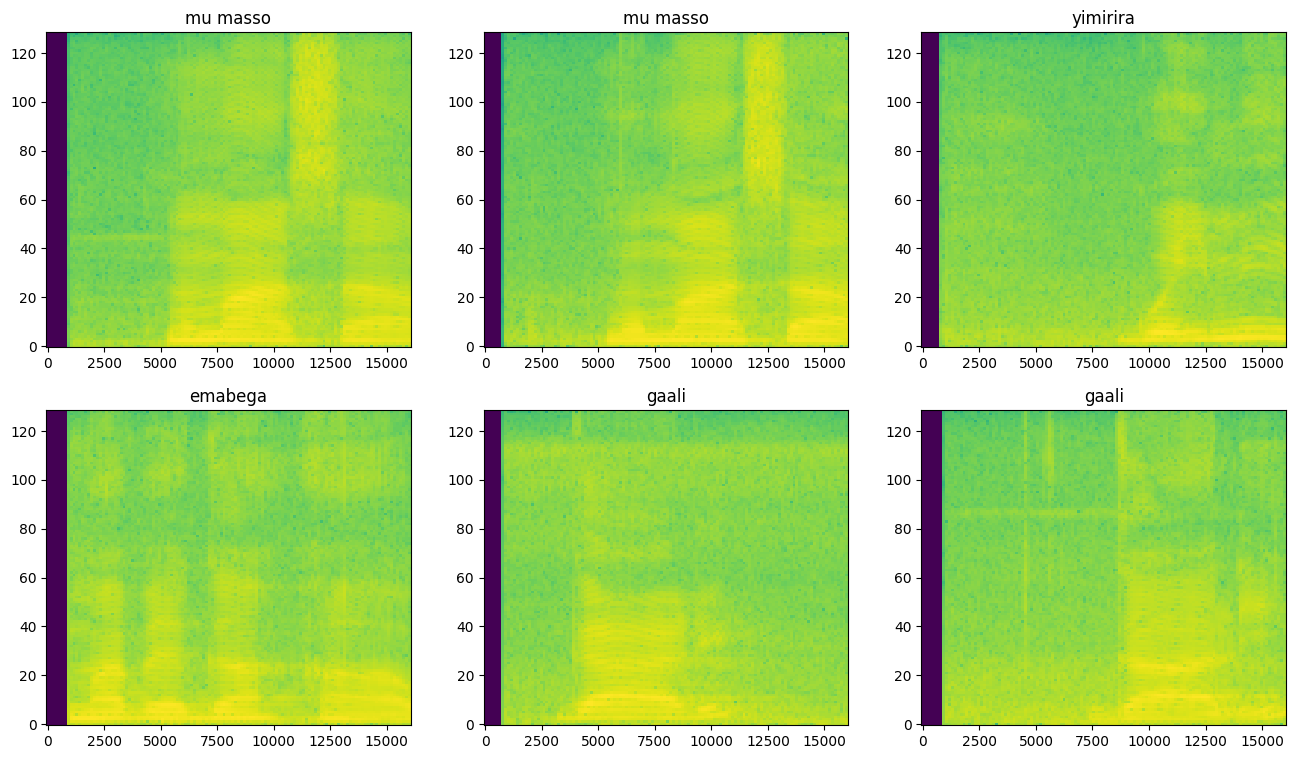

In [35]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

 `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [36]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [37]:
train_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Building Models

## Model 1

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Input shape 

In [38]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)


Input shape: (124, 129, 1)


### Normalization layer

In [39]:
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

### Model Arch

In [40]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0

### Compile the model

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [42]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


2024-02-21 13:16:22.225759: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 123863040 exceeds 10% of free system memory.
2024-02-21 13:16:22.369420: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.
2024-02-21 13:16:22.620353: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30474240 exceeds 10% of free system memory.
2024-02-21 13:16:22.646470: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30474240 exceeds 10% of free system memory.
2024-02-21 13:16:22.696393: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53215232 exceeds 10% of free system memory.


41/41 [==============================] - 97s 2s/step - loss: 1.5609 - accuracy: 0.3345 - val_loss: 1.1895 - val_accuracy: 0.5403
Epoch 2/20
41/41 [==============================] - 89s 2s/step - loss: 0.9179 - accuracy: 0.6543 - val_loss: 0.6722 - val_accuracy: 0.7500
Epoch 3/20
41/41 [==============================] - 89s 2s/step - loss: 0.5583 - accuracy: 0.8044 - val_loss: 0.4008 - val_accuracy: 0.8851
Epoch 4/20
41/41 [==============================] - 89s 2s/step - loss: 0.3894 - accuracy: 0.8665 - val_loss: 0.2860 - val_accuracy: 0.9052
Epoch 5/20
41/41 [==============================] - 90s 2s/step - loss: 0.3472 - accuracy: 0.8831 - val_loss: 0.2466 - val_accuracy: 0.9153
Epoch 6/20
41/41 [==============================] - 83s 2s/step - loss: 0.2668 - accuracy: 0.9086 - val_loss: 0.1956 - val_accuracy: 0.9294
Epoch 7/20
41/41 [==============================] - 86s 2s/step - loss: 0.2311 - accuracy: 0.9236 - val_loss: 0.1742 - val_accuracy: 0.9294
Epoch 8/20
41/41 [=============

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

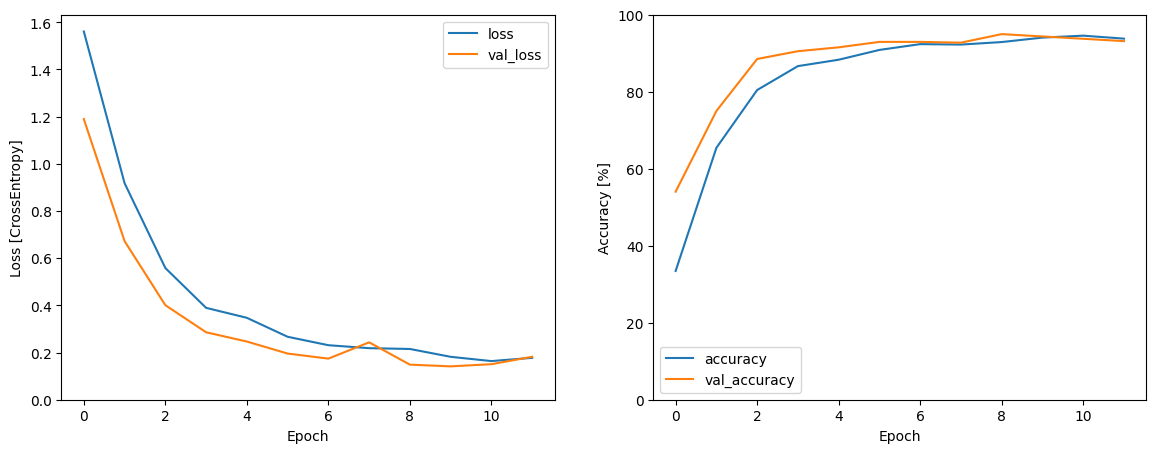

In [43]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [44]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 1s 968ms/step - loss: 2.7039 - accuracy: 0.4062


{'loss': 2.7039425373077393, 'accuracy': 0.40625}

### Display a confusion matrix

In [45]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

1/1 [==============================] - 1s 1s/step


In [46]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.2421875
Recall: 0.40625
F1-score: 0.3034638554216867


### Display the confusion matix

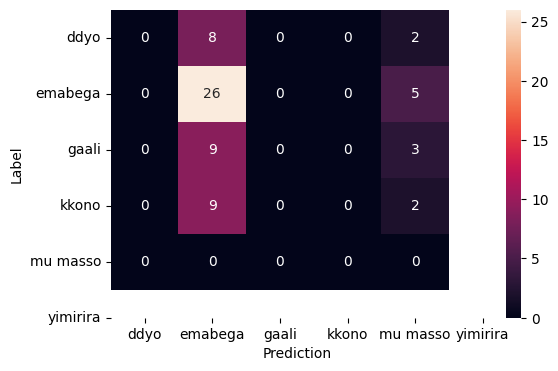

In [47]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Function to determine the size of the model

In [48]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [49]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

### Tensorflow model

In [50]:
KERAS_MODEL_NAME = "my_model_1.keras"
model.save(KERAS_MODEL_NAME)

In [51]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.301 Megabytes


### TFLite Model for model

In [52]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

2024-02-21 13:34:39.490140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-21 13:34:39.490225: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-21 13:34:39.491073: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplrsmj3vt
2024-02-21 13:34:39.496586: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-21 13:34:39.496682: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmplrsmj3vt
2024-02-21 13:34:39.508562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-21 13:34:39.513879: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-21 13:34:39.695140: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmplrsmj3vt
2024-02

In [53]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [54]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [55]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [56]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [57]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [58]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 40%


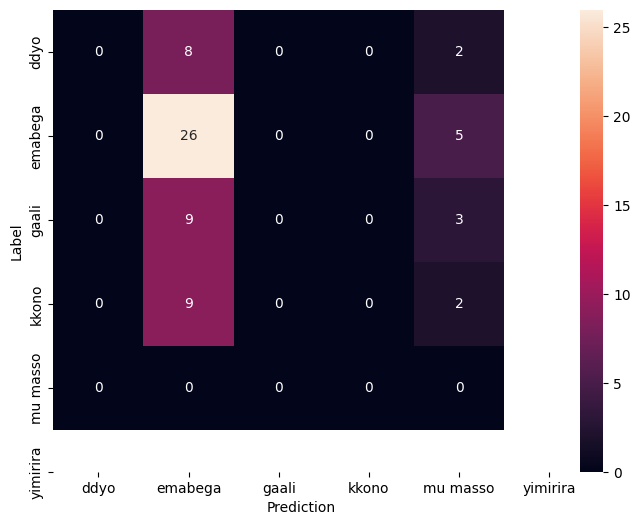

In [59]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [60]:
convert_bytes(get_file_size("model.tflite"), "KB")

File size: 436.039 Kilobytes


### Quntized model

In [61]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


2024-02-21 13:34:52.448562: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-21 13:34:52.448643: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-21 13:34:52.449397: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_unqda38
2024-02-21 13:34:52.454478: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-21 13:34:52.454539: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_unqda38
2024-02-21 13:34:52.468546: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-21 13:34:52.643746: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_unqda38
2024-02-21 13:34:52.708272: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 258879 

In [62]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 120.414 Kilobytes


In [63]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.40625


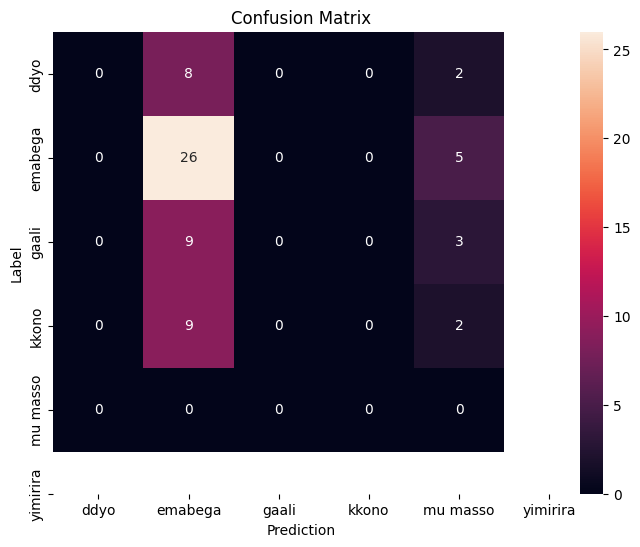

In [64]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [65]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 40%


## Model 2


1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer**: Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer**: Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers**:
   - 4.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size and ReLU activation function.
   - 4.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 4.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
5. **Convolutional Layers**:
   - 5.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size and ReLU activation function.
   - 5.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 5.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
6. **Dropout Layer**: Applies dropout regularization with a dropout rate of 0.25 to prevent overfitting.
7. **Flatten Layer**: Flattens the output of the previous layer into a 1D vector.
8. **Dense Layers**:
   - 8.1. First Dense Layer: Applies 128 neurons with ReLU activation function.
   - 8.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 8.3. Second Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Model Arch

In [66]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model2.summary()


ValueError: Exception encountered when calling layer "resizing" (type Resizing).

'images' must have either 3 or 4 dimensions.

Call arguments received by layer "resizing" (type Resizing):
  • inputs=tf.Tensor(shape=(None, 1, 124, 129, 1), dtype=float32)

### Compile the model2

In [ ]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


### Train the model

In [ ]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

### Plot Accuracy and Loss

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [56]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 0s 9ms/step - loss: 1.3133 - accuracy: 0.5312


{'loss': 1.313276767730713, 'accuracy': 0.53125}

In [57]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

6/6 [==============================] - 0s 8ms/step


In [48]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.2421875
Recall: 0.09375
F1-score: 0.13517441860465115


### Display the confusion matix

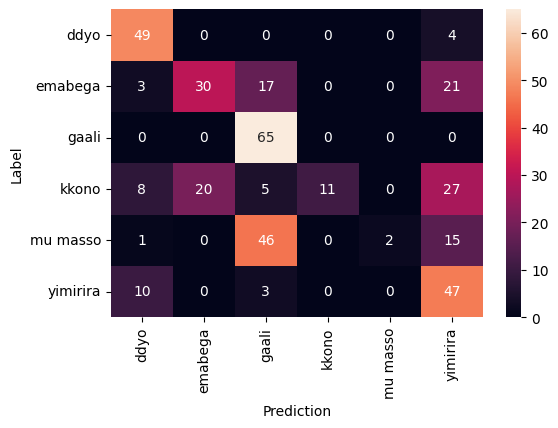

In [58]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Function to determine the size of the model

In [50]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [51]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Tensorflow model

In [52]:
KERAS_MODEL_NAME = "my_model_2.keras"
model2.save(KERAS_MODEL_NAME)

In [53]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

File size: 19091.135 Kilobytes


## TFLite Model for model

In [54]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model_2.tflite', 'wb') as f:
    f.write(tflite_model)

2024-02-21 13:09:36.971866: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-21 13:09:36.971928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-21 13:09:36.972603: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0sdycx68
2024-02-21 13:09:36.976148: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-21 13:09:36.976198: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0sdycx68
2024-02-21 13:09:36.983492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-21 13:09:36.988416: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-21 13:09:37.163460: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp0sdycx68
2024-02

In [55]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model_2.tflite')
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [56]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [57]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [58]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [59]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [60]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 9%


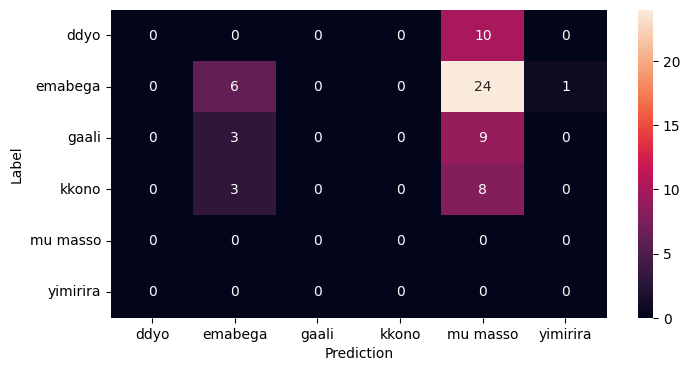

In [61]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Quntized model

In [63]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


2024-02-21 13:09:48.480092: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-21 13:09:48.480231: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-21 13:09:48.481071: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpb830jko1
2024-02-21 13:09:48.488388: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-21 13:09:48.488458: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpb830jko1
2024-02-21 13:09:48.504189: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-21 13:09:48.654459: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpb830jko1
2024-02-21 13:09:48.707096: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 226029 

In [64]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 1595.273 Kilobytes


In [65]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.09375


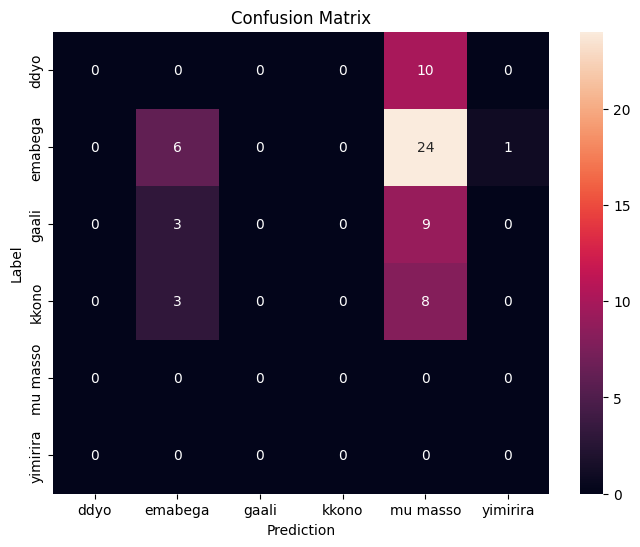

In [66]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [67]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 9%


## Model 1

1. **Input Layer:** Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer:** Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer:** Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers:** Two Conv2D layers with ReLU activation functions, followed by max pooling.
5. **Dropout Layer:** Applies dropout regularization to prevent overfitting.
6. **Flatten Layer:** Flattens the output of the previous layer into a 1D vector.
7. **Dense Layers:** Two Dense layers with ReLU activation functions, followed by the output layer with logits for each class.

### Model Arch

In [52]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

### Compile the model

In [53]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [54]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 13s 223ms/step - loss: 0.7560 - accuracy: 0.7052 - val_loss: 0.3150 - val_accuracy: 0.8958
Epoch 2/10
45/45 [==============================] - 9s 202ms/step - loss: 0.2841 - accuracy: 0.9059 - val_loss: 0.1808 - val_accuracy: 0.9375
Epoch 3/10
45/45 [==============================] - 9s 190ms/step - loss: 0.1812 - accuracy: 0.9358 - val_loss: 0.1213 - val_accuracy: 0.9524
Epoch 4/10
45/45 [==============================] - 8s 168ms/step - loss: 0.1428 - accuracy: 0.9542 - val_loss: 0.1167 - val_accuracy: 0.9702
Epoch 5/10
45/45 [==============================] - 7s 165ms/step - loss: 0.1060 - accuracy: 0.9670 - val_loss: 0.1053 - val_accuracy: 0.9583
Epoch 6/10
45/45 [==============================] - 8s 169ms/step - loss: 0.0944 - accuracy: 0.9674 - val_loss: 0.0694 - val_accuracy: 0.9702
Epoch 7/10
45/45 [==============================] - 8s 170ms/step - loss: 0.0763 - accuracy: 0.9760 - val_loss: 0.0749 - val_accuracy: 0.9702
Epoch

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

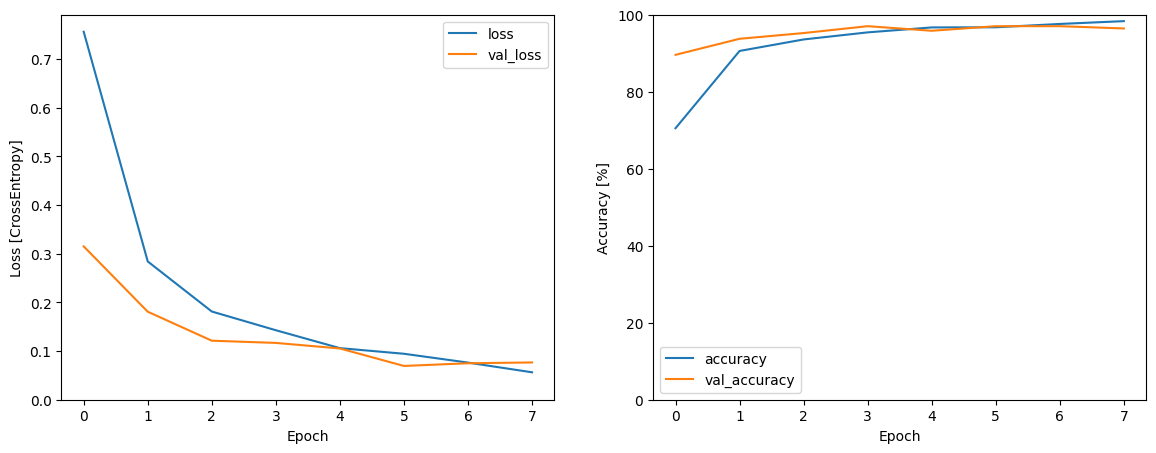

In [55]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [56]:
model.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 1s 69ms/step - loss: 0.0508 - accuracy: 0.9818


{'loss': 0.05080313980579376, 'accuracy': 0.9817708134651184}

### Display a confusion matrix

In [37]:
y_pred = model.predict(test_spectrogram_ds)

6/6 [==============================] - 0s 41ms/step


In [38]:
y_pred = tf.argmax(y_pred, axis=1)

In [39]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

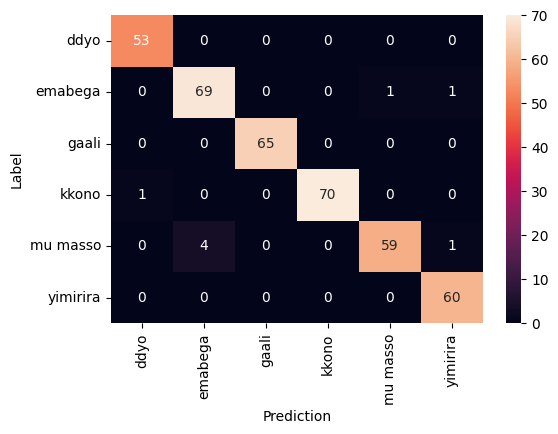

In [40]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 2


1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer**: Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer**: Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers**:
   - 4.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size and ReLU activation function.
   - 4.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 4.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
5. **Convolutional Layers**:
   - 5.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size and ReLU activation function.
   - 5.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 5.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
6. **Dropout Layer**: Applies dropout regularization with a dropout rate of 0.25 to prevent overfitting.
7. **Flatten Layer**: Flattens the output of the previous layer into a 1D vector.
8. **Dense Layers**:
   - 8.1. First Dense Layer: Applies 128 neurons with ReLU activation function.
   - 8.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 8.3. Second Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Model Arch

In [58]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization_2 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                      

### Compile the  Model

In [59]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


### Train the Model

In [60]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 9s 113ms/step - loss: 1.0477 - accuracy: 0.6976 - val_loss: 1.4836 - val_accuracy: 0.5804
Epoch 2/10
45/45 [==============================] - 5s 101ms/step - loss: 0.3048 - accuracy: 0.8955 - val_loss: 1.4280 - val_accuracy: 0.4435
Epoch 3/10
45/45 [==============================] - 4s 94ms/step - loss: 0.1783 - accuracy: 0.9354 - val_loss: 1.6343 - val_accuracy: 0.3720
Epoch 4/10
45/45 [==============================] - 4s 93ms/step - loss: 0.1457 - accuracy: 0.9472 - val_loss: 1.8444 - val_accuracy: 0.3810
Epoch 4: early stopping


### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

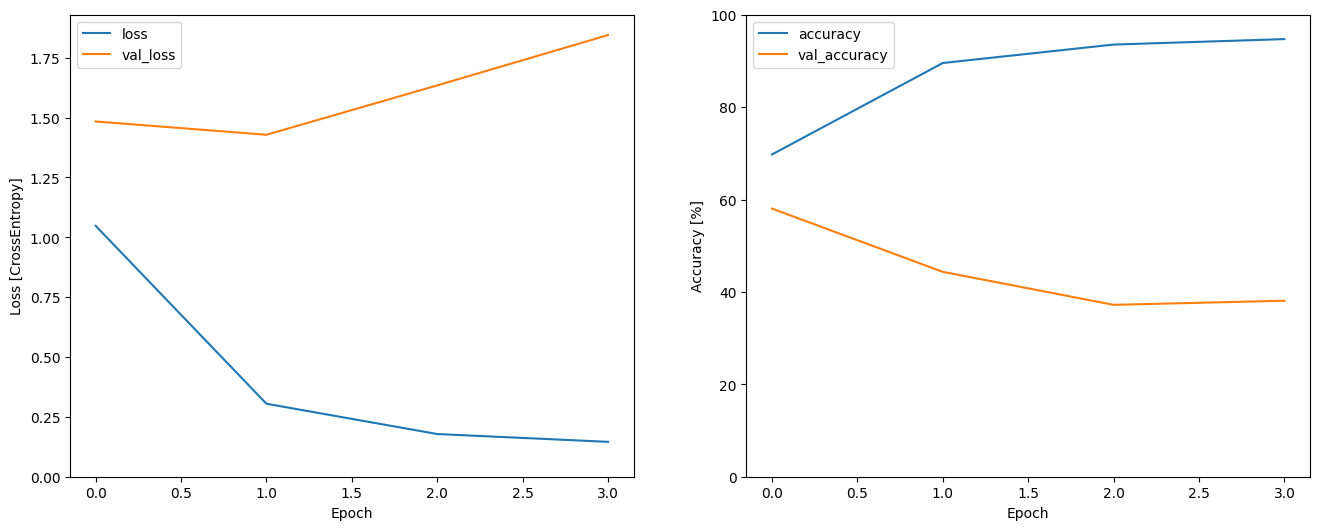

In [62]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [47]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 0s 30ms/step - loss: 0.9828 - accuracy: 0.6979


{'loss': 0.9827563762664795, 'accuracy': 0.6979166865348816}

### Display a confusion matrix

In [64]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

6/6 [==============================] - 0s 24ms/step


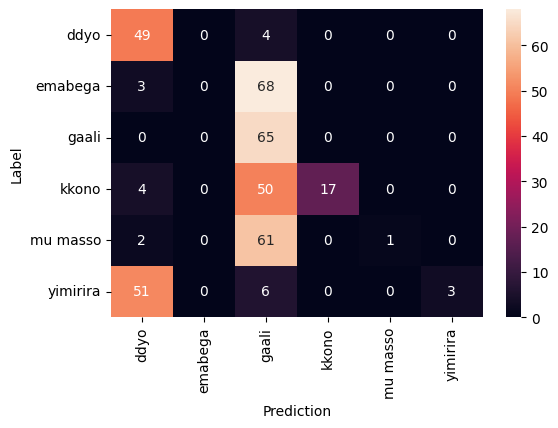

In [65]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 3

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Model Arch

In [67]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d_1  (None, 128)              

### Model compile

In [68]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [69]:
EPOCHS = 10
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 83s 2s/step - loss: 1.4584 - accuracy: 0.3906 - val_loss: 0.9884 - val_accuracy: 0.6488
Epoch 2/10
45/45 [==============================] - 80s 2s/step - loss: 0.7785 - accuracy: 0.7069 - val_loss: 0.5167 - val_accuracy: 0.8244
Epoch 3/10
45/45 [==============================] - 76s 2s/step - loss: 0.4535 - accuracy: 0.8354 - val_loss: 0.2995 - val_accuracy: 0.9167
Epoch 4/10
45/45 [==============================] - 75s 2s/step - loss: 0.3155 - accuracy: 0.8885 - val_loss: 0.2461 - val_accuracy: 0.9107
Epoch 5/10
45/45 [==============================] - 69s 2s/step - loss: 0.2531 - accuracy: 0.9080 - val_loss: 0.1977 - val_accuracy: 0.9196
Epoch 6/10
45/45 [==============================] - 68s 2s/step - loss: 0.2171 - accuracy: 0.9253 - val_loss: 0.1717 - val_accuracy: 0.9524
Epoch 7/10
45/45 [==============================] - 74s 2s/step - loss: 0.2116 - accuracy: 0.9240 - val_loss: 0.1659 - val_accuracy: 0.9345
Epoch 8/10
45/45 [==

### Plot Loaa and accuracy

Text(0, 0.5, 'Accuracy [%]')

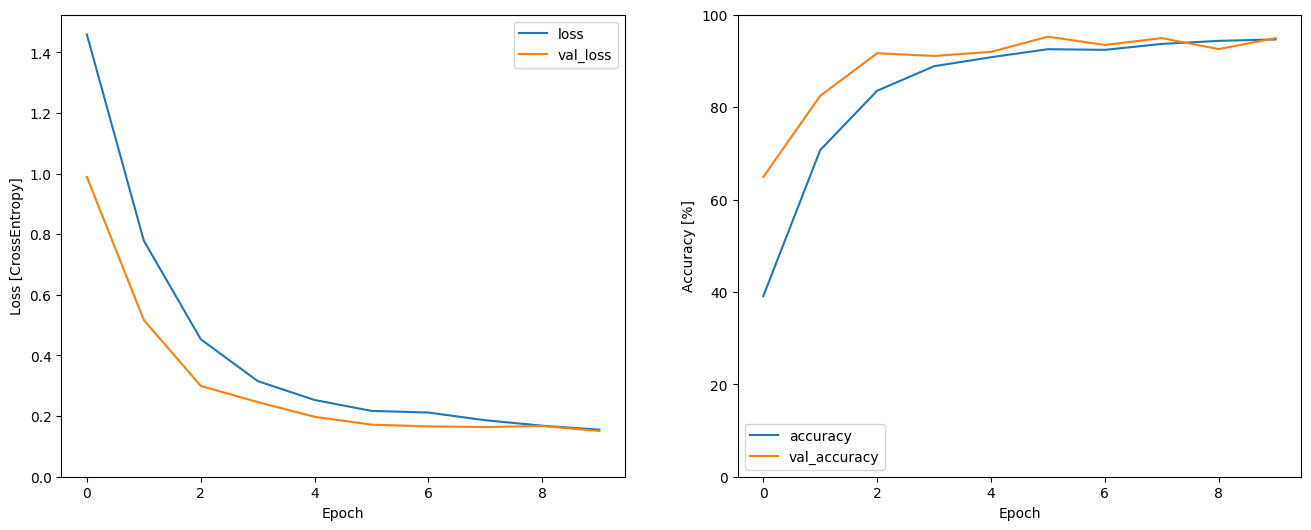

In [70]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [71]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 3s 570ms/step - loss: 0.1150 - accuracy: 0.9583


{'loss': 0.1149514690041542, 'accuracy': 0.9583333134651184}

### Display a confusion matrix

In [73]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

6/6 [==============================] - 4s 733ms/step


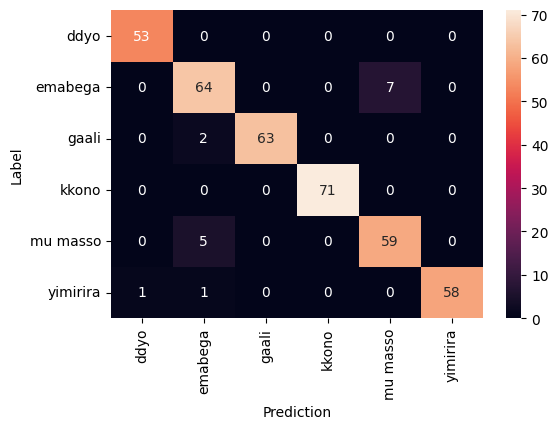

In [74]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 4


1. **Preprocessing**:
   - The `train_spectrogram_ds` and `val_spectrogram_ds` datasets are mapped to convert grayscale spectrogram images to RGB format using `tf.image.grayscale_to_rgb()`.
2. **Input Shape**:
   - The input shape is specified as `(124, 129, 3)` to match the dimensions of RGB spectrogram images.
3. **Base Model**:
   - The MobileNetV2 model is used as the base model, which is pre-trained on ImageNet and has its top layers removed (`include_top=False`). 
   - `input_shape` is set to `(124, 129, 3)` to match the input shape of the RGB spectrogram images.
   - Weights are initialized from the ImageNet pre-trained weights (`weights='imagenet'`).
   - The base model is frozen (`base_model.trainable = False`) to prevent its weights from being updated during training.
4. **Model Architecture**:
   - The base MobileNetV2 model is followed by:
     - **GlobalAveragePooling2D Layer**: Performs global average pooling to reduce the spatial dimensions of the feature maps.
     - **Dense Layer**: Applies 128 neurons with ReLU activation function.
     - **Dropout Layer**: Applies dropout regularization with a dropout rate of 0.5.
     - **Dense Layer**: Outputs logits for each class, with the number of units equal to the number of labels.

This architecture leverages transfer learning from the pre-trained MobileNetV2 model and fine-tunes it for the spectrogram image classification task. The base MobileNetV2 model extracts relevant features from the spectrogram images, and the additional layers are trained to classify these features into the specified classes.

### Model Arch

In [75]:
train_spectrogram_ds = train_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
val_spectrogram_ds = val_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

input_shape = (124, 129, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                                 
Total params: 2422726 (9.24 MB)
Trainable params: 1647

### Model compile

In [77]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train a model

In [78]:
EPOCHS = 10
history = model4.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 48s 757ms/step - loss: 0.8929 - accuracy: 0.6896 - val_loss: 0.3448 - val_accuracy: 0.8988
Epoch 2/10
45/45 [==============================] - 27s 597ms/step - loss: 0.3488 - accuracy: 0.8875 - val_loss: 0.2325 - val_accuracy: 0.9345
Epoch 3/10
45/45 [==============================] - 27s 589ms/step - loss: 0.2315 - accuracy: 0.9260 - val_loss: 0.1764 - val_accuracy: 0.9435
Epoch 4/10
45/45 [==============================] - 26s 576ms/step - loss: 0.2038 - accuracy: 0.9361 - val_loss: 0.1626 - val_accuracy: 0.9524
Epoch 5/10
45/45 [==============================] - 27s 604ms/step - loss: 0.1531 - accuracy: 0.9486 - val_loss: 0.1553 - val_accuracy: 0.9524
Epoch 6/10
45/45 [==============================] - 27s 594ms/step - loss: 0.1392 - accuracy: 0.9563 - val_loss: 0.1376 - val_accuracy: 0.9464
Epoch 7/10
45/45 [==============================] - 28s 623ms/step - loss: 0.1044 - accuracy: 0.9677 - val_loss: 0.1294 - val_accuracy: 0.9583

### Plot Loss and Accuracy

Text(0, 0.5, 'Accuracy [%]')

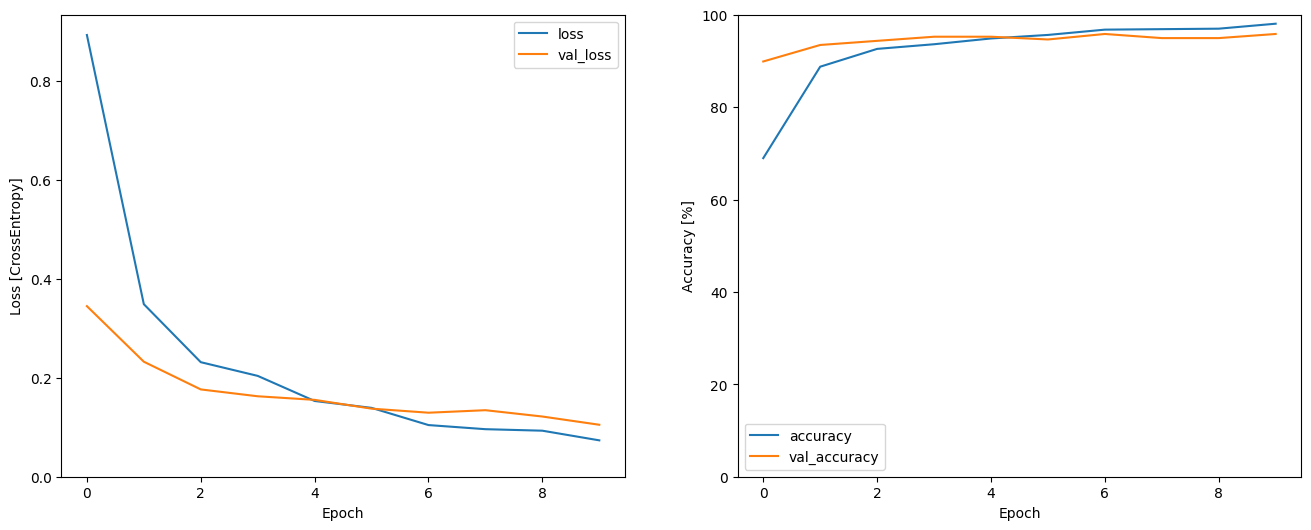

In [79]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [80]:
model4.evaluate(val_spectrogram_ds, return_dict=True)


6/6 [==============================] - 3s 460ms/step - loss: 0.1050 - accuracy: 0.9583


{'loss': 0.1050272136926651, 'accuracy': 0.9583333134651184}

### Display the confusion matrix

In [81]:
y_pred = model4.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

6/6 [==============================] - 5s 476ms/step


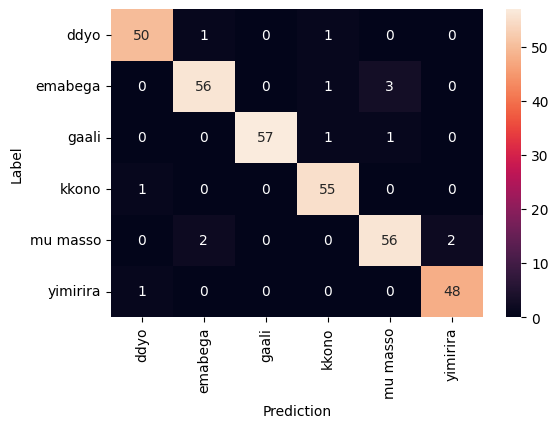

In [82]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Exporting a model

## Export the model with preprocessing

In [83]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [84]:
export = ExportModel(model)
export(tf.constant(str('own/ddyo/audio #2001.wav')))

{'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[10.113076  , -3.5361385 ,  3.0876963 , -0.51724124,  2.8615477 ,
         -3.46595   ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'ddyo'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [85]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'kkono'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-1.5817771, -0.5885717,  1.8026869, 18.221415 , -3.745662 ,
         -5.2800074]], dtype=float32)>}

### Visualize the audio waveform

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Loading Raw Audio Data

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each speech command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

## Mount google drive
adisamproject@gmail.com

In [3]:
# drive.mount('/content/drive')

### On colab Notebooks
uncomment these lines for loading in data

In [4]:
# DATASET_PATH = "/content/drive/My Drive/2_Luganda/dataset"
# data_dir = pathlib.Path(DATASET_PATH)

### Locally on the pc

In [5]:
DATASET_PATH = 'own/'
data_dir = pathlib.Path(DATASET_PATH)
OUTPUT_PATH = 'output/'

# Inspect the audio data

## Label Names

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Insect one audio file

In [7]:
example_audio_path = 'own/ddyo/audio #2001.wav'
audio_signal, sample_rate = librosa.load(example_audio_path)

In [8]:
audio = wave.open(example_audio_path, 'rb')

### Audio Parameters

In [9]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [10]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 16000
Number of frames: 15360
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=15360, comptype='NONE', compname='not compressed')


In [11]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 0.96 seconds
Sample Rate: 22050 Hz


### Visualize the audio waveform

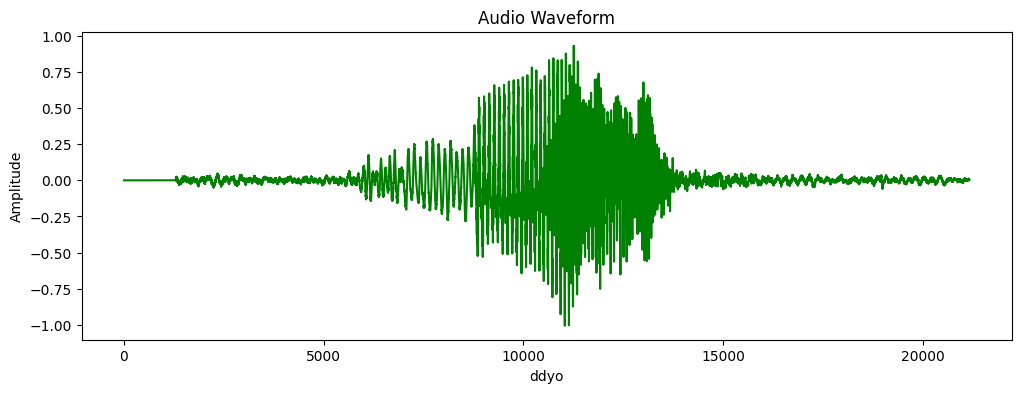

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(audio_signal, color='green')
plt.title('Audio Waveform')
plt.xlabel('ddyo')
plt.ylabel('Amplitude')
plt.show()

### Amplitude Distribution

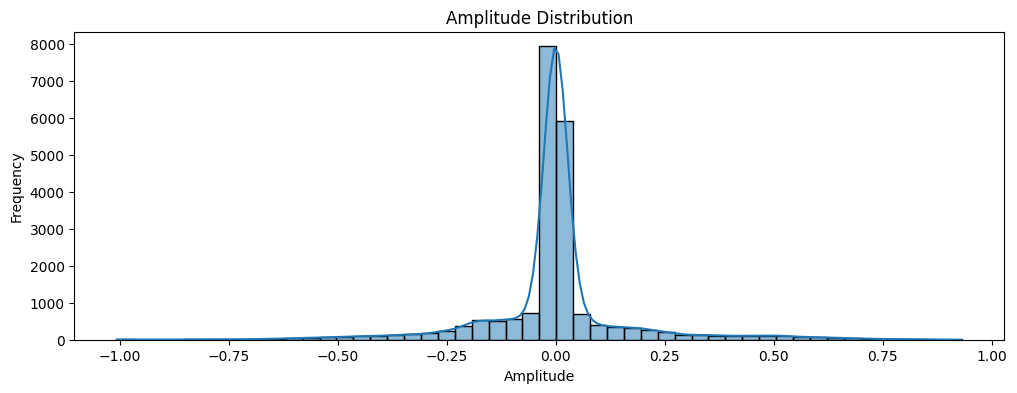

In [13]:
plt.figure(figsize=(12, 4))
sns.histplot(audio_signal, bins=50, kde=True)
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()


## Number of audio files per command

In [14]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}

    # Iterate through subfolders
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Count the number of audio files in the subfolder
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count

    return counts

# Get the counts
counts = count_audio_files_in_subfolders(data_dir)
counts

{'emabega': 600,
 'ddyo': 600,
 'gaali': 600,
 'kkono': 600,
 'mu masso': 600,
 'yimirira': 600}

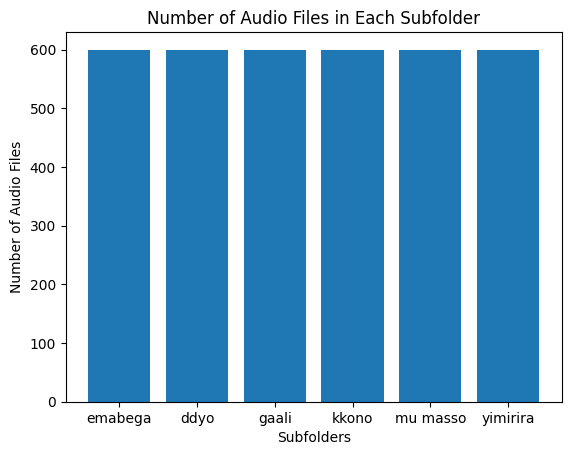

In [15]:
### Bar graph showing number of audio files per command
plt.bar(counts.keys(), counts.values())
plt.xlabel('Subfolders')
plt.ylabel('Number of Audio Files')
plt.title('Number of Audio Files in Each Subfolder')
plt.show()

# Split into Train and validation

In [16]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3600 files belonging to 6 classes.
Using 2880 files for training.
Using 720 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


### The audio clips have a shape of `(batch, samples, channels)`.

In [17]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [18]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [19]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [20]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### Plot a few audio waveforms:

In [21]:
label_names[[1,2,3,0,4,5]]

array(['emabega', 'gaali', 'kkono', 'ddyo', 'mu masso', 'yimirira'],
      dtype='<U8')

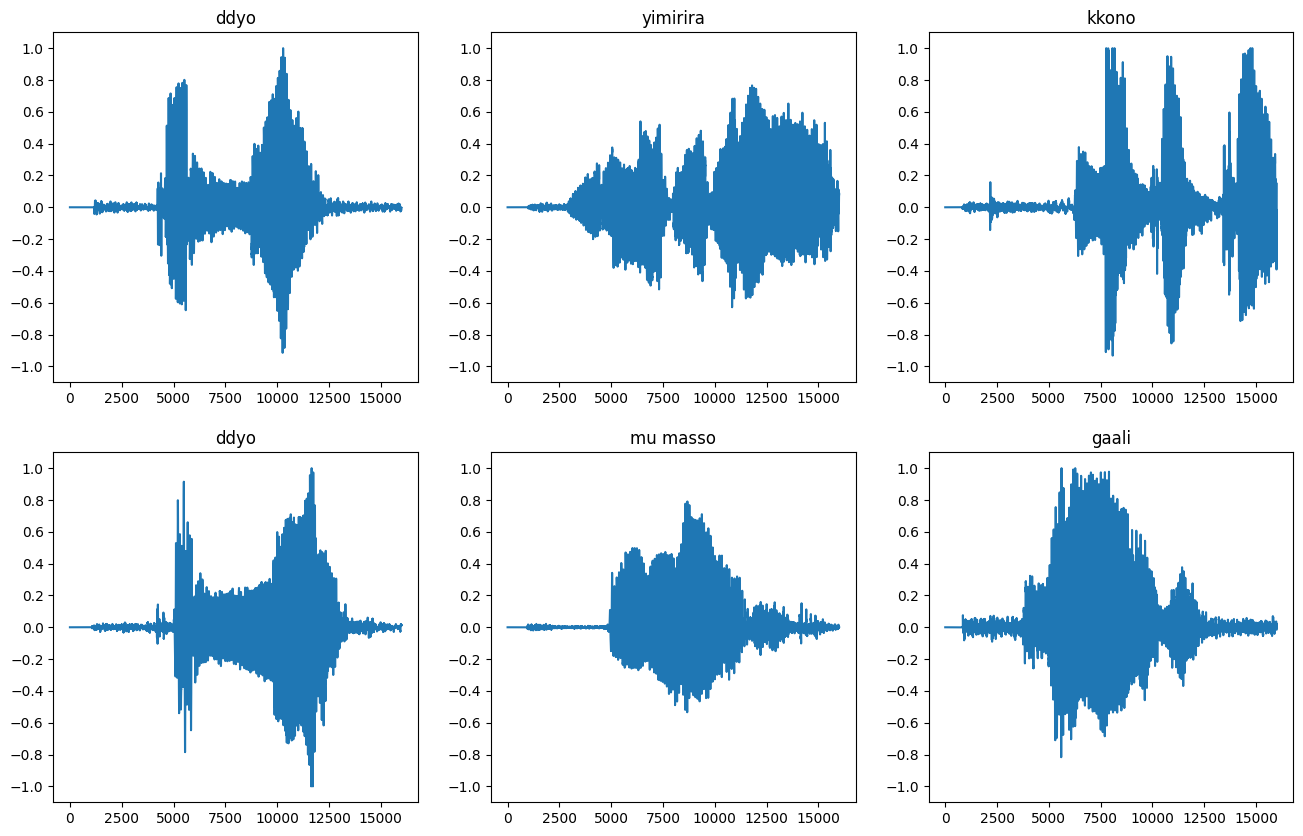

In [22]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [23]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio:

In [24]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yimirira
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: kkono
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Displaying a spectrogram:

In [25]:
# Convert the frequencies to log scale and transpose, so that the time is
# represented on the x-axis (columns).
# Add an epsilon to avoid taking a log of zero.

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform over time and the corresponding spectrogram.

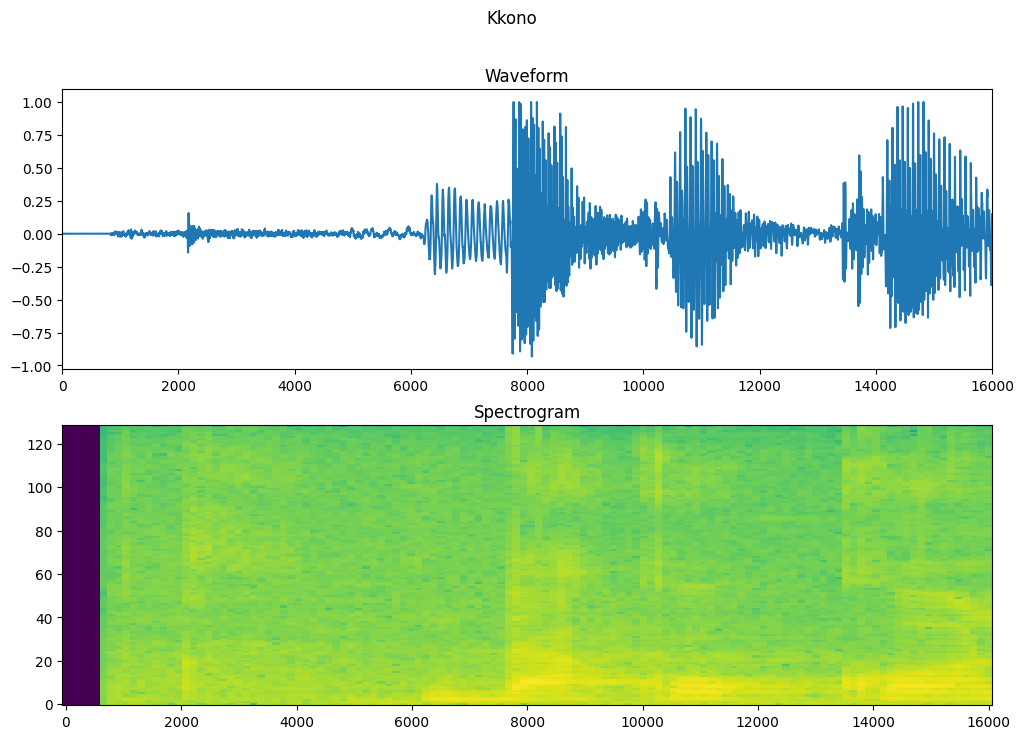

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets from the audio datasets:

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

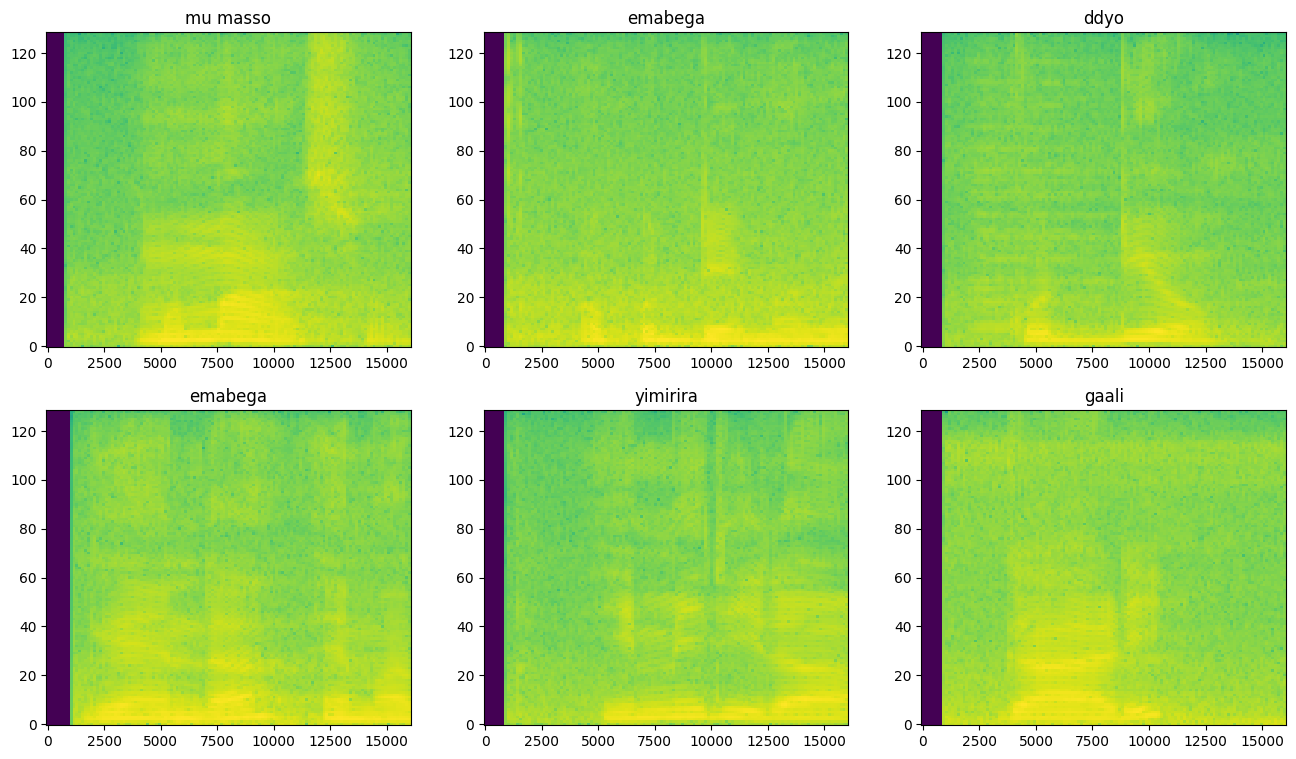

In [30]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

### `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [31]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model 1

In [32]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

### Keras model with the Adam optimizer and the cross-entropy loss:

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [34]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 12s 204ms/step - loss: 0.7705 - accuracy: 0.7066 - val_loss: 0.2877 - val_accuracy: 0.9196
Epoch 2/10
45/45 [==============================] - 8s 180ms/step - loss: 0.2982 - accuracy: 0.8976 - val_loss: 0.1799 - val_accuracy: 0.9345
Epoch 3/10
45/45 [==============================] - 8s 180ms/step - loss: 0.1919 - accuracy: 0.9299 - val_loss: 0.1230 - val_accuracy: 0.9583
Epoch 4/10
45/45 [==============================] - 8s 182ms/step - loss: 0.1269 - accuracy: 0.9552 - val_loss: 0.1125 - val_accuracy: 0.9583
Epoch 5/10
45/45 [==============================] - 8s 179ms/step - loss: 0.1056 - accuracy: 0.9639 - val_loss: 0.1126 - val_accuracy: 0.9613
Epoch 6/10
45/45 [==============================] - 8s 179ms/step - loss: 0.0889 - accuracy: 0.9698 - val_loss: 0.0971 - val_accuracy: 0.9732
Epoch 7/10
45/45 [==============================] - 8s 180ms/step - loss: 0.0850 - accuracy: 0.9743 - val_loss: 0.0956 - val_accuracy: 0.9732
Epoch

### Plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

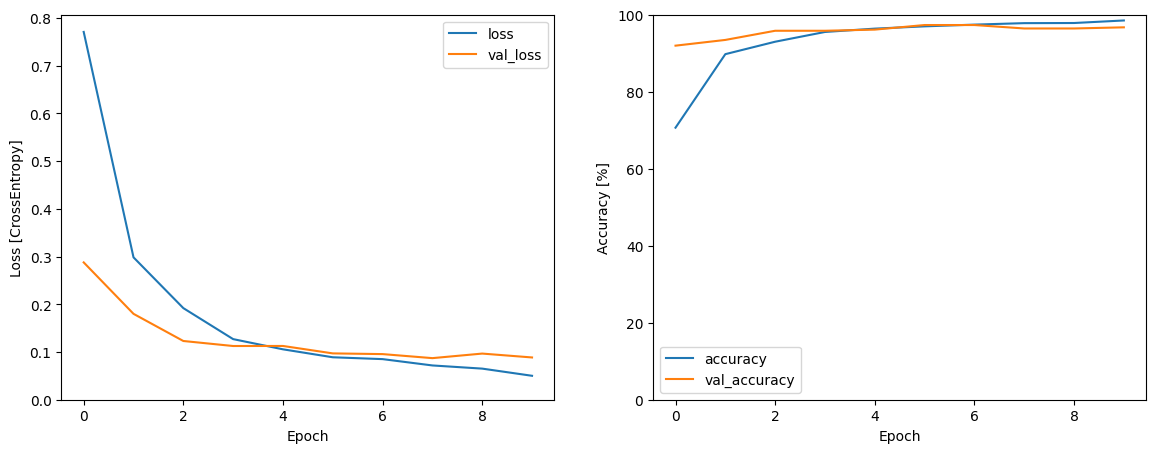

In [35]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [36]:
model.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 1s 60ms/step - loss: 0.0493 - accuracy: 0.9792


{'loss': 0.04932880029082298, 'accuracy': 0.9791666865348816}

### Display a confusion matrix

In [37]:
y_pred = model.predict(test_spectrogram_ds)

6/6 [==============================] - 0s 41ms/step


In [38]:
y_pred = tf.argmax(y_pred, axis=1)

In [39]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [4]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

NameError: name 'y_true' is not defined

### Export the model with preprocessing

In [41]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

## Model 2

In [42]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [43]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                      

In [44]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


In [45]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 9s 98ms/step - loss: 0.9990 - accuracy: 0.6958 - val_loss: 1.3941 - val_accuracy: 0.6577
Epoch 2/10
45/45 [==============================] - 4s 90ms/step - loss: 0.2860 - accuracy: 0.9000 - val_loss: 1.2581 - val_accuracy: 0.5119
Epoch 3/10
45/45 [==============================] - 4s 85ms/step - loss: 0.1923 - accuracy: 0.9333 - val_loss: 1.1484 - val_accuracy: 0.5208
Epoch 4/10
45/45 [==============================] - 4s 87ms/step - loss: 0.1354 - accuracy: 0.9542 - val_loss: 1.1035 - val_accuracy: 0.5208
Epoch 5/10
45/45 [==============================] - 4s 83ms/step - loss: 0.1069 - accuracy: 0.9625 - val_loss: 0.8286 - val_accuracy: 0.7202
Epoch 6/10
45/45 [==============================] - 4s 80ms/step - loss: 0.0866 - accuracy: 0.9691 - val_loss: 1.2746 - val_accuracy: 0.4821
Epoch 7/10
45/45 [==============================] - 4s 90ms/step - loss: 0.0808 - accuracy: 0.9705 - val_loss: 0.8048 - val_accuracy: 0.6696
Epoch 8/10
45

Text(0, 0.5, 'Accuracy [%]')

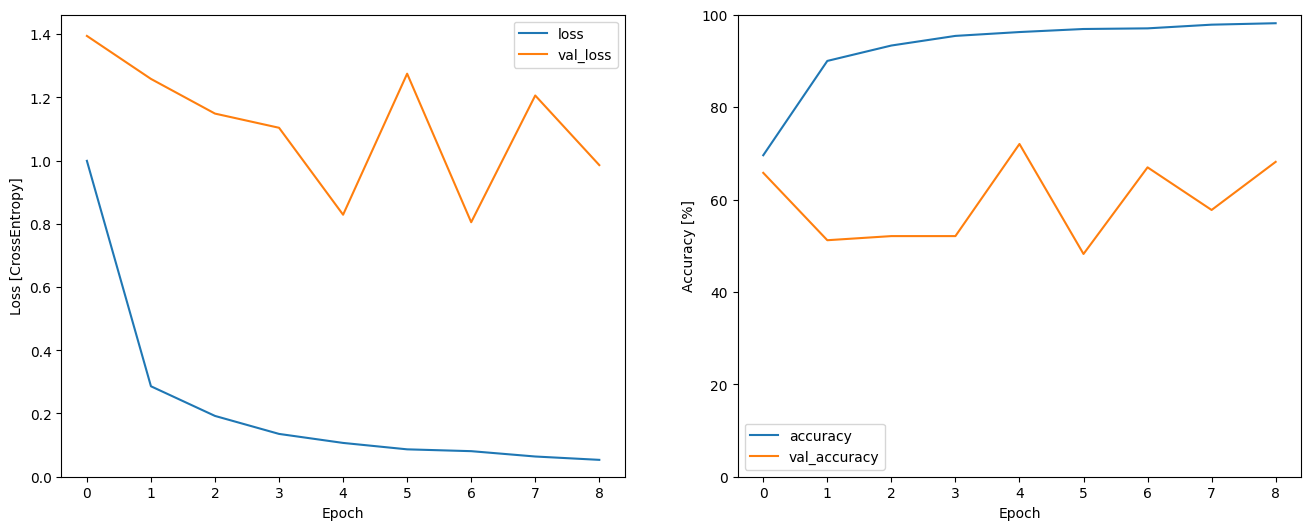

In [46]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [47]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 0s 30ms/step - loss: 0.9828 - accuracy: 0.6979


{'loss': 0.9827563762664795, 'accuracy': 0.6979166865348816}

In [48]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 0s 23ms/step


In [49]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

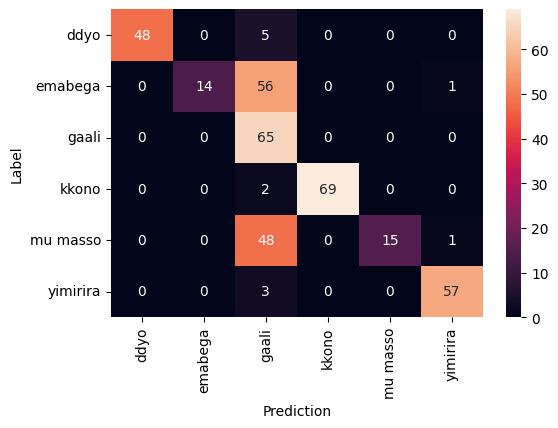

In [50]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 3

In [51]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [52]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)              

In [53]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [54]:
EPOCHS = 10
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 69s 1s/step - loss: 1.5114 - accuracy: 0.3653 - val_loss: 1.0292 - val_accuracy: 0.6756
Epoch 2/10
45/45 [==============================] - 63s 1s/step - loss: 0.7885 - accuracy: 0.7073 - val_loss: 0.5013 - val_accuracy: 0.8333
Epoch 3/10
45/45 [==============================] - 62s 1s/step - loss: 0.4676 - accuracy: 0.8382 - val_loss: 0.3269 - val_accuracy: 0.8839
Epoch 4/10
45/45 [==============================] - 62s 1s/step - loss: 0.3294 - accuracy: 0.8806 - val_loss: 0.2428 - val_accuracy: 0.9018
Epoch 5/10
45/45 [==============================] - 63s 1s/step - loss: 0.2533 - accuracy: 0.9094 - val_loss: 0.2152 - val_accuracy: 0.9315
Epoch 6/10
45/45 [==============================] - 63s 1s/step - loss: 0.2365 - accuracy: 0.9167 - val_loss: 0.2036 - val_accuracy: 0.9345
Epoch 7/10
45/45 [==============================] - 64s 1s/step - loss: 0.2067 - accuracy: 0.9264 - val_loss: 0.1612 - val_accuracy: 0.9464
Epoch 8/10
45/45 [==

Text(0, 0.5, 'Accuracy [%]')

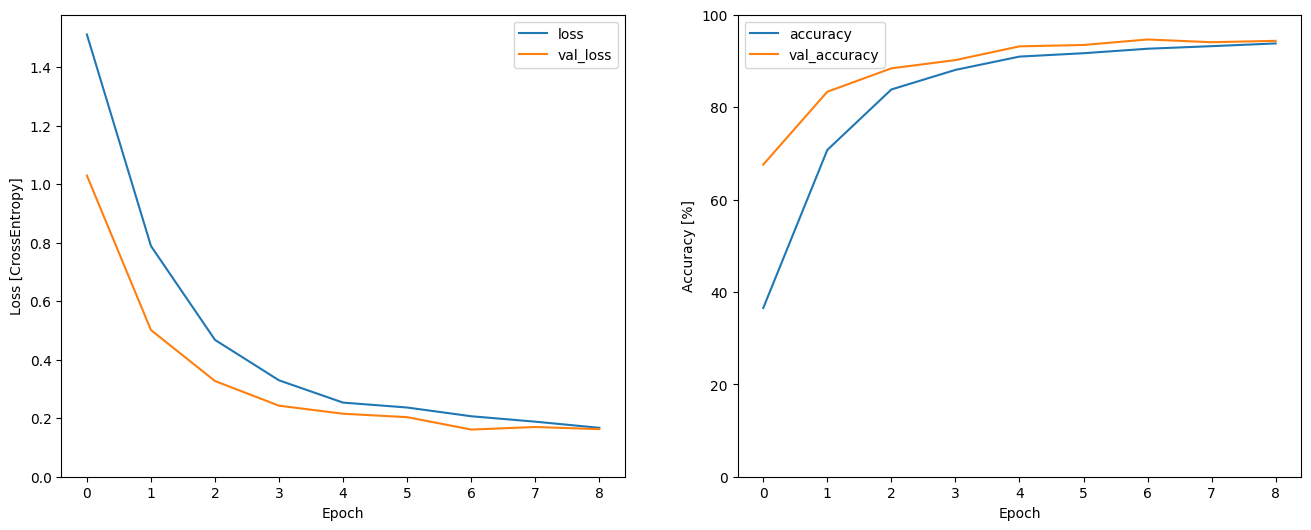

In [55]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [56]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 3s 546ms/step - loss: 0.1594 - accuracy: 0.9453


{'loss': 0.15940314531326294, 'accuracy': 0.9453125}

In [57]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 4s 559ms/step


In [58]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

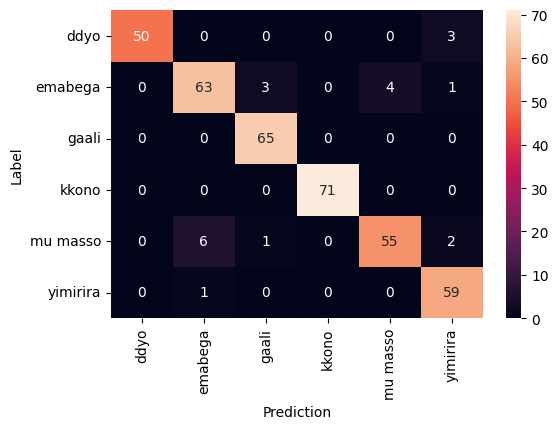

In [59]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 4

In [60]:

train_spectrogram_ds = train_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
val_spectrogram_ds = val_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

In [61]:
input_shape = (124, 129, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [62]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2422726 (9.24 MB)
Trainable params: 1647

In [63]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [64]:
EPOCHS = 10
history = model4.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 35s 607ms/step - loss: 0.7950 - accuracy: 0.7160 - val_loss: 0.3128 - val_accuracy: 0.9048
Epoch 2/10
45/45 [==============================] - 23s 504ms/step - loss: 0.2995 - accuracy: 0.8976 - val_loss: 0.2352 - val_accuracy: 0.9256
Epoch 3/10
45/45 [==============================] - 23s 502ms/step - loss: 0.2094 - accuracy: 0.9319 - val_loss: 0.1890 - val_accuracy: 0.9375
Epoch 4/10
45/45 [==============================] - 23s 509ms/step - loss: 0.1812 - accuracy: 0.9420 - val_loss: 0.1670 - val_accuracy: 0.9405
Epoch 5/10
45/45 [==============================] - 23s 503ms/step - loss: 0.1537 - accuracy: 0.9524 - val_loss: 0.1496 - val_accuracy: 0.9524
Epoch 6/10
45/45 [==============================] - 23s 515ms/step - loss: 0.1212 - accuracy: 0.9552 - val_loss: 0.1520 - val_accuracy: 0.9464
Epoch 7/10
45/45 [==============================] - 22s 497ms/step - loss: 0.1057 - accuracy: 0.9642 - val_loss: 0.1297 - val_accuracy: 0.9583

Text(0, 0.5, 'Accuracy [%]')

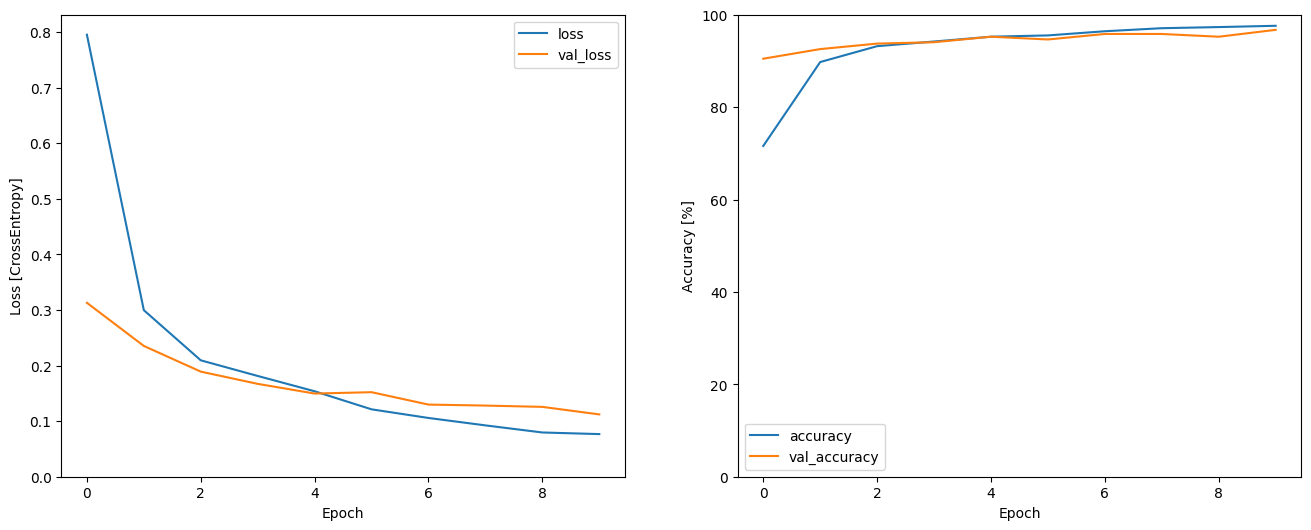

In [65]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [66]:
model4.evaluate(val_spectrogram_ds, return_dict=True)


6/6 [==============================] - 3s 400ms/step - loss: 0.1121 - accuracy: 0.9673


{'loss': 0.11207960546016693, 'accuracy': 0.9672619104385376}

In [67]:
y_pred = model4.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 5s 401ms/step


In [68]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

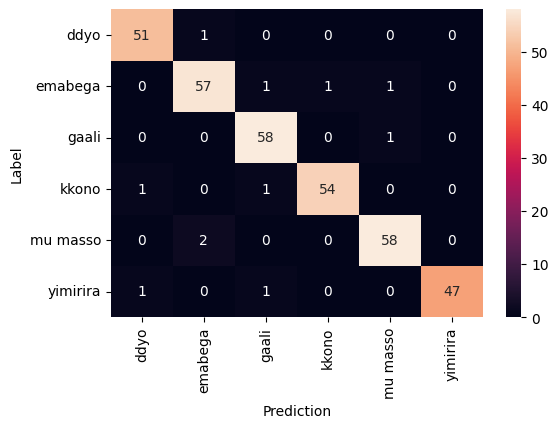

In [69]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Exporting a model

## Export the model with preprocessing

In [70]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [71]:
export = ExportModel(model)
export(tf.constant(str('own/ddyo/audio #2001.wav')))

{'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 9.465372 , -2.913904 ,  1.8329071, -2.3481178,  1.8404739,
         -0.6110423]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'ddyo'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [72]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'kkono'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-1.4268333, -2.4481032, -2.6611438, 17.355558 , -8.48692  ,
         -7.552232 ]], dtype=float32)>}